In [1]:
!pip install anvil-uplink

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 KB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 KB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ws4py: filename=ws4py-0.5.1-py3-none-any.whl size=45229 sha256=16860539ef558b6a3f6974da5fd1343e848a723b3cf59f4c6d60eac1faea4d2a
  Stored in directory: /root/.cache/pip/wheels/ea/f9/a1/34e2943cce3cf7daca304bfc35e91280694ced9194a487ce2f
Successfully built ws4py


In [2]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [3]:
from getpass import getpass
uplink_key = getpass('Введите код подключения: ')

KeyboardInterrupt: ignored

In [4]:
import anvil.server
import anvil.media
import dlib
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from random import  randint
import imageio
from tensorflow_docs.vis import embed

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
anvil.server.connect('NTXEJANHZSR75P43BLXKLRQH-2EE2356KPGYLOYQC')

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment" as SERVER


In [7]:
model_test = load_model('/content/drive/MyDrive/my_app/model7.h5')
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("/content/drive/MyDrive/my_app/shape_predictor_68_face_landmarks.dat")

In [8]:
def load_faces (path, max_frames=-1, resize=(80, 80)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame_g = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # Захватываем фрейм в ч/б формате 
            faces = detector(frame_g) # Ищем лицо
            if len(faces) >0:
              frame = frame_g[faces[0].top():faces[0].bottom(),faces[0].left():faces[0].right()] # Вырезаем лицо
              try:
                frame = cv2.resize(frame, resize) # Приводим к заданному размеру
                frames.append(frame)
              except:
                continue
            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames) # Возвращаем массив лиц из видео

@anvil.server.callable
def predict_action(file, model = model_test ):
    facesLoaded = True
    classes = {0: 'гнев', 1 : 'отвращение', 2 : 'страх', 3 : 'счастье', 4 : 'нейтральное состояние', 5 : 'печаль', 6 : 'удивление'}
    with anvil.media.TempFile(file) as filename:
      frames = load_faces(filename)
      if len(frames) == 0:
        facesLoaded = False
      elif len(frames)>20:
        countfr = len(frames)-20
        temp_pred = []
        for i in range(countfr):
            temp_pred.append(frames[i:i+20])
        pred =np.array(temp_pred)/255    
        pred = pred.reshape(countfr,20,80,80,1)

        b = randint(0,len(frames)-20)
        frames = frames[b:b+20]
        #frames = frames[0:20]
        frames = frames.reshape(20,80,80,1)
      else:
         diff = 20 - len(frames)
         padding = np.zeros((diff, 80, 80, 1))
         frames = frames.reshape(len(frames),80,80,1)
         frames = np.concatenate((frames, padding))
         pred = frames[None, ...]/255

    if facesLoaded:
      probabilities = model.predict(pred)[0]
      for i in np.argsort(probabilities)[::-1]:
        print(f"  {classes[i]}: {probabilities[i] * 100:5.2f}%")
      emo = f"Человек на видео испытывает {classes[np.argmax(probabilities)]}"
    else:
      emo = 'На видео не найдено лицо человека'  
    return emo, frames

@anvil.server.callable
def to_gif(images):
    converted_images = np.asarray(images)
    #converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")

In [9]:
anvil.server.wait_forever()

2/2 [==============================] - 11s 1s/step
  счастье: 99.58%
  нейтральное состояние:  0.42%
  удивление:  0.00%
  отвращение:  0.00%
  гнев:  0.00%
  печаль:  0.00%
  страх:  0.00%
8/8 [==============================] - 3s 398ms/step
  печаль: 83.02%
  отвращение: 13.09%
  счастье:  3.40%
  нейтральное состояние:  0.31%
  страх:  0.17%
  гнев:  0.00%
  удивление:  0.00%
2/2 [==============================] - 1s 935ms/step
  удивление: 99.29%
  счастье:  0.37%
  нейтральное состояние:  0.34%
  гнев:  0.00%
  отвращение:  0.00%
  страх:  0.00%
  печаль:  0.00%
1/1 [==============================] - 2s 2s/step
  удивление: 58.41%
  счастье: 34.51%
  нейтральное состояние:  6.78%
  отвращение:  0.27%
  страх:  0.03%
  гнев:  0.00%
  печаль:  0.00%
3/3 [==============================] - 1s 342ms/step
  удивление: 99.95%
  отвращение:  0.04%
  нейтральное состояние:  0.00%
  счастье:  0.00%
  страх:  0.00%
  гнев:  0.00%
  печаль:  0.00%
3/3 [==============================] - 2s 989

KeyboardInterrupt: ignored

In [ ]:
test_path = '/content/drive/MyDrive/my_app/0.mp4' 

In [ ]:
emo,test_frames = predict_action(test_path)

2/2 [==============================] - 0s 153ms/step
  гнев: 86.39%
  нейтральное состояние: 10.77%
  счастье:  2.15%
  печаль:  0.41%
  отвращение:  0.28%
  удивление:  0.00%
  страх:  0.00%


Test video path: /content/drive/MyDrive/my_app/0.mp4
2/2 [==============================] - 0s 158ms/step
  гнев: 86.39%
  нейтральное состояние: 10.77%
  счастье:  2.15%
  печаль:  0.41%
  отвращение:  0.28%
  удивление:  0.00%
  страх:  0.00%
Человек на видео испытывает гнев



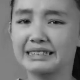

In [ ]:
print(f"Test video path: {test_path}")
test_frames = predict_action(test_path)
to_gif(test_frames)